In [1]:
## imports 

import sys; sys.path.insert(0,'..')
import random, math, os
import numpy as np
import pyzx as zx
from fractions import Fraction
from pyzx import gflow as gf
from numpy import pi
from typing import Union
import matplotlib.pyplot as plt

#### Flow Experiments 

In [2]:
fname = os.path.join('..','circuits','Fast', 'mod5_4_before')
circ = zx.Circuit.load(fname)
# Alternatively we could have done:
# circ = zx.Circuit.from_quipper_file(fname)
circ.gates

[NOT(4),
 HAD(4),
 CCZ(c1=0,c2=3,t=4),
 CCZ(c1=2,c2=3,t=4),
 HAD(4),
 CNOT(3,4),
 HAD(4),
 CCZ(c1=1,c2=2,t=4),
 HAD(4),
 CNOT(2,4),
 HAD(4),
 CCZ(c1=0,c2=1,t=4),
 HAD(4),
 CNOT(1,4),
 CNOT(0,4)]

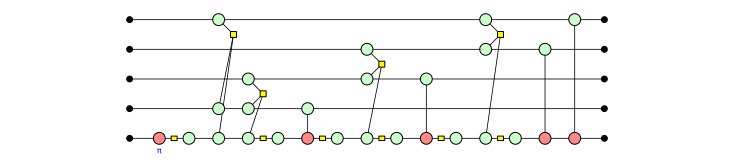

In [3]:
zx.draw_matplotlib(circ, figsize=(10,2), h_edge_draw='box')

In [4]:
grp = circ.to_graph()
zx.simplify.interior_clifford_simp(grp, quiet= True)

grp.normalize()

In [5]:
zx.draw(grp)

In [6]:
grp_flow = gf.gflow(grp)

#### Stabilser for $R_{ZZ}$ based resource state 


In [7]:
import qiskit 
import qiskit.quantum_info as qi
from qiskit.circuit import Parameter, ParameterExpression, ParameterExpression, library
from qiskit.opflow import X, Y, Z, I, PauliOp, PauliSumOp
from qiskit.quantum_info import Pauli

def extract_coeff(sum_pauli_op: qiskit.opflow.list_ops.summed_op.SummedOp ):
    dic = {}
    for item in sum_pauli_op : 

        phase = (-1j)**(item.primitive.phase)
        pstr = item.primitive / phase ; #pstr = pstr.to_label()
        coeff = item.coeff * phase 

        if pstr in dic.keys():
            dic[pstr] = dic[pstr] + coeff
        else :
            dic[pstr] = coeff

    return dic

def pauli_string(op: PauliOp, n:int,  loc: list = None):

    lis = [0]*n
    if op != I :
        for i in loc: lis[i] = 1

        if op == X: return qi.Pauli(([0]*n, lis))
        elif op == Z: return qi.Pauli((lis, [0]*n))
        elif op == Y: return qi.Pauli((lis, lis))    

    elif op == I: return qi.Pauli(([0]*n, [0]*n))


def rzz(index:list, n):
    
    assert len(index) == 2
    rzz_th = lambda th : PauliOp(pauli_string( I, n), coeff=np.cos(th /2)) + PauliOp(pauli_string( Z, n, index), coeff= -1j * np.sin(th /2))

    return rzz_th


def resolve_iz(dic: dict, index: int = 1):
    
    coeff_i = 0.0; coeff_z = 0.0
    for items in dic.items() :
        # print(items ) ##
        pstr = items[0].to_label()

        # print(pstr) ##    
        if pstr[-1 - index] == 'I':
            coeff_i += items[1]

        elif pstr[-1 - index] == 'Z':
            coeff_z += items[1]

    return [ PauliOp( Pauli('I'), coeff = coeff_i), PauliOp( Pauli('Z'), coeff = coeff_z) ]

th = Parameter('th')

def plot_IZ_coeffs(opn_r):
    p_I = []; p_Z = []; angle_range = np.linspace(0, 2*pi, 100)
    for angle in angle_range:

        p_I.append(opn_r[0].bind_parameters({th: angle}).coeff) ; p_Z.append(opn_r[1].bind_parameters({th: angle}).coeff)

    plt.plot(angle_range, p_I, label = 'I')
    plt.plot(angle_range, p_Z, label = 'Z')
    plt.axhline(0.0)
    plt.title('# neighbours = ' + str())
    plt.legend()
    plt.show()

In [8]:
num = 2
op = PauliOp(pauli_string(X, num, [0]), coeff= 1.00)
entangle_command = lambda th : rzz([0,1],num)(th) #@ rzz([0,2],num)(th) #@ rzz([0,3],num)(th) @ rzz([0,4],num)(th)
op_cj = entangle_command(th).to_pauli_op().reduce() @ op @ entangle_command(-1* th).to_pauli_op().reduce()
op_cj = op_cj.reduce().to_pauli_op()
opn2 = extract_coeff(op_cj); opn2_r = resolve_iz(opn2, index = 1)

In [9]:
opn2

{Pauli('IX'): ParameterExpression(-1.0*sin(th/2)**2 + 1.0*cos(th/2)**2),
 Pauli('ZY'): ParameterExpression(2.0*sin(th/2)*cos(th/2))}

In [10]:
print(op, list(opn2.keys()), sep= " -> " )

IX -> [Pauli('IX'), Pauli('ZY')]


In [11]:
num = 3
op = PauliOp(pauli_string(X, num, [0]), coeff= 1.00)
entangle_command = lambda th : rzz([0,1],num)(th) @ rzz([0,2],num)(th) #@ rzz([0,3],num)(th) @ rzz([0,4],num)(th)
op_cj = entangle_command(th).to_pauli_op().reduce() @ op @ entangle_command(-1* th).to_pauli_op().reduce()
op_cj = op_cj.reduce().to_pauli_op()
opn3 = extract_coeff(op_cj) ; opn3_r = resolve_iz(opn3, index = 1)

In [12]:
print(op, list(opn3.keys()), sep= " -> " )

IIX -> [Pauli('IIX'), Pauli('ZIY'), Pauli('IZY'), Pauli('ZZX')]


In [13]:
num = 4
op = PauliOp(pauli_string(X, num, [0]), coeff= 1.00)
entangle_command = lambda th : rzz([0,1],num)(th) @ rzz([0,2],num)(th) @ rzz([0,3],num)(th) #@ rzz([0,4],num)(th)
op_cj = entangle_command(th).to_pauli_op().reduce() @ op @ entangle_command(-1* th).to_pauli_op().reduce()
op_cj = op_cj.reduce().to_pauli_op()
opn4 = extract_coeff(op_cj) ; opn4_r = resolve_iz(opn4, index= 1)

In [14]:
print(op, list(opn4.keys()), sep= " -> " )

IIIX -> [Pauli('IIIX'), Pauli('ZIIY'), Pauli('IZIY'), Pauli('ZZIX'), Pauli('IIZY'), Pauli('ZIZX'), Pauli('IZZX'), Pauli('ZZZY')]


In [15]:
num = 5
op = PauliOp(pauli_string(X, num, [0]), coeff= 1.00)
entangle_command = lambda th : rzz([0,1],num)(th) @ rzz([0,2],num)(th) @ rzz([0,3],num)(th) @ rzz([0,4],num)(th)
op_cj = entangle_command(th).to_pauli_op().reduce() @ op @ entangle_command(-1* th).to_pauli_op().reduce()
op_cj = op_cj.reduce().to_pauli_op()
opn5 = extract_coeff(op_cj); opn5_r = resolve_iz(opn5, index= 1)

In [16]:
print(op, list(opn5.keys()), sep= " -> " )

IIIIX -> [Pauli('IIIIX'), Pauli('ZIIIY'), Pauli('IZIIY'), Pauli('ZZIIX'), Pauli('IIZIY'), Pauli('ZIZIX'), Pauli('IZZIX'), Pauli('ZZZIY'), Pauli('IIIZY'), Pauli('ZIIZX'), Pauli('IZIZX'), Pauli('ZZIZY'), Pauli('IIZZX'), Pauli('ZIZZY'), Pauli('IZZZY'), Pauli('ZZZZX')]


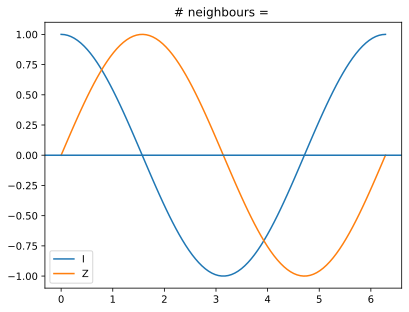

In [17]:
plot_IZ_coeffs(opn2_r)

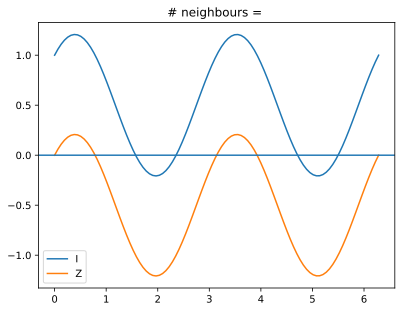

In [18]:
plot_IZ_coeffs(opn3_r)

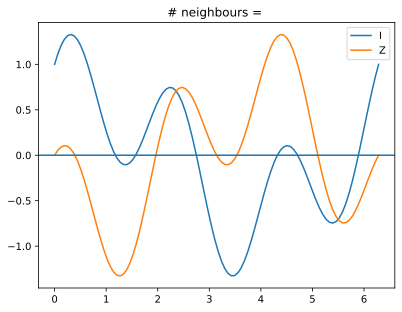

In [19]:
plot_IZ_coeffs(opn4_r)

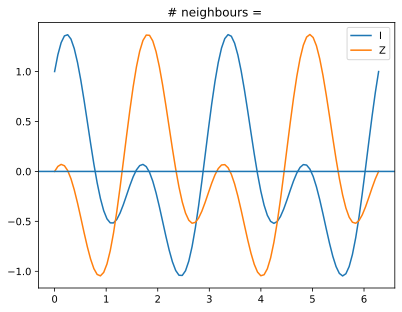

In [20]:
plot_IZ_coeffs(opn5_r)

In [23]:
th / np. pi 

ParameterExpression(0.318309886183791*th)